## Imports

In [21]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import gensim.downloader as gensim_api 

from tqdm import tqdm 
tqdm.pandas()
import gc

In [22]:
train_dset_df = pd.read_csv("2020_10_19_train_dset_df_nostem_nostoprem.csv")
test_dset_df = pd.read_csv("2020_10_19_test_dset_df_nostem_nostoprem.csv")

train_dset_df["preprocessed_joined"].fillna("", inplace=True)
test_dset_df["preprocessed_joined"].fillna("", inplace=True)

train_dset_y = train_dset_df["target"].to_numpy()

In [23]:
NUM_TRAIN_EXAMPLES = len(train_dset_df)

## Embedder function

In [24]:
def embedding_entire_dset(dset_df_rows, embedding_vectors):
    '''
    dset_df_rows: A pandas Series. Each entry is a string of space-separated words without numbers and special characters.
    embedding_vectors: A non-trainable embedding vectors instance from Gensim 
    num_embedding_columns: The number of columns.
    ''' 
    num_embedding_columns=300
    num_embedding_rows = len(dset_df_rows)
    mean_embedding_X = np.zeros((num_embedding_rows, num_embedding_columns))
    sum_embedding_X = np.zeros((num_embedding_rows, num_embedding_columns))
    min_embedding_X = np.zeros((num_embedding_rows, num_embedding_columns))
    max_embedding_X = np.zeros((num_embedding_rows, num_embedding_columns))
    for row_index in tqdm(range(num_embedding_rows)):
        words = [word for word in dset_df_rows[row_index].split() if word in embedding_vectors]
        if(len(words) > 0):
            sentence_embedding_matrix = embedding_vectors[words]
            mean_embedding_X[row_index,:] = np.mean(sentence_embedding_matrix,axis=0)
            sum_embedding_X[row_index,:] = np.sum(sentence_embedding_matrix, axis=0)
            min_embedding_X[row_index,:] = np.min(sentence_embedding_matrix, axis=0)
            max_embedding_X[row_index,:] = np.max(sentence_embedding_matrix, axis=0)
    embedding_X = np.concatenate([mean_embedding_X, sum_embedding_X, min_embedding_X, max_embedding_X], axis=1)
    return embedding_X


## Metricsifier

In [25]:
from sklearn.metrics import f1_score, plot_confusion_matrix, precision_score, recall_score

In [26]:
def summarize(model, X, y):
    yhat = model.predict(X)
    print("F1 score:", f1_score(y, yhat))
    print("Precision:", precision_score(y, yhat))
    print("Recall:", recall_score(y, yhat))
    print("Confusion matrix:")
    plot_confusion_matrix(model, X, y)
    plt.show()

## SGDC With Cross-validation

Tried SGDC squared_hinge  400 iters alpha 0.0001 weights 1 : 2.5 eta0 0.00001 validation f1 score 0.58

Tried SGDC modified_huber 400 iters alpha 0.0001 weights 1:  2.5 eta0 0.000001
Validation f1 score 0.58

Conclusion: SGDC on the current dataset saturates at 0.58

In [27]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [28]:
# kfcv = KFold(n_splits=10, shuffle=True)
# kfcv_array = np.array(list(range(NUM_TRAIN_EXAMPLES))).reshape(-1, 1)
# for train_indices, test_indices in kfcv.split(kfcv_array):
#     sgdc = SGDClassifier(loss="squared_hinge", alpha=0.01, class_weight={0:1, 1:2.5}, learning_rate="constant", eta0 = 0.000001)
#     word2vec = gensim_api.load("word2vec-google-news-300")
#     train_embedded_X = embedding_entire_dset(train_dset_df["preprocessed_joined"],word2vec)
#     word2vec = None 
#     [gc.collect() for i in range(3)]
#     scaler = StandardScaler()
#     train_embedded_X = scaler.fit_transform(train_embedded_X)
#     scaler = None 
#     [gc.collect() for i in range(3)]
#     trainset_embedded_X = train_embedded_X[train_indices,:]
#     trainset_y = train_dset_y[train_indices]
#     testset_embedded_X = train_embedded_X[test_indices,:]
#     testset_y = train_dset_y[test_indices]
#     train_embedded_X = None 
#     [gc.collect() for i in range(3)]
#     for i in range(400):
#         sgdc.partial_fit(trainset_embedded_X, trainset_y, classes=(0, 1))
#         trainset_yhat = sgdc.predict(trainset_embedded_X)
#         trainset_yhat = np.round(trainset_yhat)
#         new_train_f1_score = f1_score(trainset_y, trainset_yhat)
#         print(i)
#         print("\tTRAIN F1 score:", new_train_f1_score)

#     print("\n\nTRAINING:")
#     summarize(sgdc, trainset_embedded_X, trainset_y)

#     print("\nTESTING:")
#     summarize(sgdc, testset_embedded_X, testset_y)
#     sgdc = None 
#     trainset_y = None 
#     trainset_embedded_X = None 
#     testset_embedded_X = None 
#     testset_y = None
#     [gc.collect() for i in range(3)]
    



    

## Correlation analysis

In [29]:
word2vec = gensim_api.load("word2vec-google-news-300")
train_embedded_X = embedding_entire_dset(train_dset_df["preprocessed_joined"],word2vec)
scaler = StandardScaler()
train_embedded_X = scaler.fit_transform(train_embedded_X)

100%|██████████| 783673/783673 [01:13<00:00, 10608.45it/s]


In [30]:
from scipy.stats import spearmanr

In [31]:
spearman_correlations = []
for column_id in tqdm(range(train_embedded_X.shape[1])):
    spearman_correlations.append((column_id,spearmanr(train_embedded_X[:,column_id], train_dset_y)))

100%|██████████| 1200/1200 [02:28<00:00,  8.08it/s]


In [33]:
corrs_without_index = [ spearmanr_result[1].correlation for spearmanr_result in spearman_correlations]

In [35]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

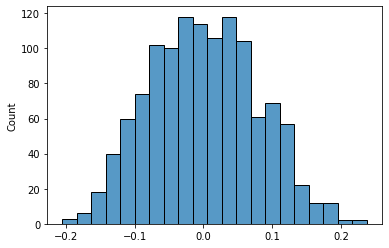

In [36]:
sns.histplot(corrs_without_index)

### Conclusion: There are hardly any features where it seems like that feature will have a major correlation with the target. It is not possible to remove features.